<a href="https://colab.research.google.com/github/roijo/AD-DL/blob/master/PipelineADNI_0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Early signs and interpretability of diffuse brain damage on mild brain lesions and early/mild cognitive decline: a pilot study**.#




#1. Introduction#
*To which extent can a CNN classify radiological 
clinical labels in early and mild diffuse brain damage 
to healthy and diseased patients?*


#2. Methods#

Which type of CNN are we using? Why have we chosen this type?
Role of empirical approach:

1. [Several types of convolutional neural network](https://towardsdatascience.com/various-types-of-convolutional-neural-network-8b00c9a08a1b)
2. [Functions of ML methods](https://towardsdatascience.com/e2e-the-every-purpose-ml-method-5d4f20dafee4)

3. [End-to-end interpretation](https://www-nature-com.proxy.kib.ki.se/articles/sdata201449)




##*Databases and datasets*##

 Amount of data per subject
The influence of the amount of data per subject on reliability has been extensively explored. The acquisition of more frames of data is associated with greater reliability, whether through longer scan durations (Birn et al., 2013; Mejia et al., 2018; Mueller et al., 2015; Noble et al., 2017b; Shah et al., 2016; Tomasi et al., 2016), higher sampling rates (Birn et al., 2013), or multiple scans (Noble et al., 2017b). That said, different strategies for increasing data had different effects. 

For the same total number of frames, longer scan durations improved reliability more than higher sampling rates (Shah et al., 2016; although not part of the qualitative analysis, similar results were found by Horien et al., 2018a). 

For the same total scan time, averaging data across multiple sessions acquired farther apart in time (e.g., weeks) resulted in a more reliable measure than averaging across consecutive sessions (e.g., weeks instead of minutes). Relatedly, the use of a low-pass or narrow filter (i.e., discarding high frequency information) reduced both reliability and signal-noise separation (Shirer et al., 2015).

---

Following, we define datasets and address locations, formats and types using nibabel capabilities within Google Cloud environment as well as access control.

In [2]:
# Authentication protocols and interfaces
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

from pathlib import Path
root_path = Path('gdrive/My Drive/TBIproject/ADNI') #change dir to your project folder
HC_path = Path('/content/gdrive/My Drive/TBIproject/ADNI/HC')
MCI_path = Path('/content/gdrive/My Drive/TBIproject/ADNI/MCI')

##Save list files for log purposes
# HC paths
HC_vols = [
    os.path.join(os.getcwd(), HC_path, x)
    for x in os.listdir(HC_path)]

# MCI paths
MCI_vols = [
    os.path.join(os.getcwd(), MCI_path, x)
    for x in os.listdir(MCI_path)]

#Convert to Dataframes
#HC_vols = pd.DataFrame(HC_vols)
#MCI_vols = pd.DataFrame(MCI_vols)

#Write a .csv for log purposes
with open("HC_vols.csv", "w") as outfile:
    outfile.write("\n".join(HC_vols))

with open("MCI_vols.csv", "w") as outfile:
    outfile.write("\n".join(MCI_vols))

%load_ext google.colab.data_table
#df = pd.read_csv("HC_vols.csv")

Mounted at /content/gdrive


##*Preprocessing and QC*##

Controlling for the quality of data is essential further to preprocessing...

##*Exploratory Data Analysis*##

Analysis of variables and factors of interest to this modelling and statistical considerations for group and longitudinal design. Matters related to outliers, necessary number of sets, addressing of cohorts, overfitting, hyperparameter tunning and transfer learning  to come.



##*Base imports and definintions*##


In [3]:
## Main packages
!pip install -q nipype
!pip install -q nilearn
#.Package to read NiFTI files
!pip install -q nibabel
#.Install the PyDrive wrapper
#.This only needs to be done once
!pip install -U -q PyDrive

## Main imports
import random
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")
#.Find files recursively
from glob import glob
#.Progress bar for iterations
from tqdm import tqdm_notebook, tnrange

## Graphic interfaces and elements
import matplotlib.pylab as plt
plt.style.use("ggplot")
sns.set_style('white')
plt.set_cmap('gist_gray')
#.Nifti loader Nibabel and skimage
import nibabel as nib
from nibabel import data, dataobj_images
from scipy import ndimage
from skimage.io import imread, imshow, concatenate_images
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import label
#pyplot side, sets the backend of matplotlib to the 'inline' backend
%matplotlib inline
#.OpenCV for image dialogue inheritance
import cv2


     |████████████████████████████████| 3.2MB 16.0MB/s 
     |████████████████████████████████| 235kB 55.0MB/s 
     |████████████████████████████████| 573kB 58.3MB/s 
     |████████████████████████████████| 133kB 60.3MB/s 
     |████████████████████████████████| 430kB 53.3MB/s 
     |████████████████████████████████| 51kB 10.3MB/s 
     |████████████████████████████████| 3.0MB 21.1MB/s 


##*Images Visualization*##
---
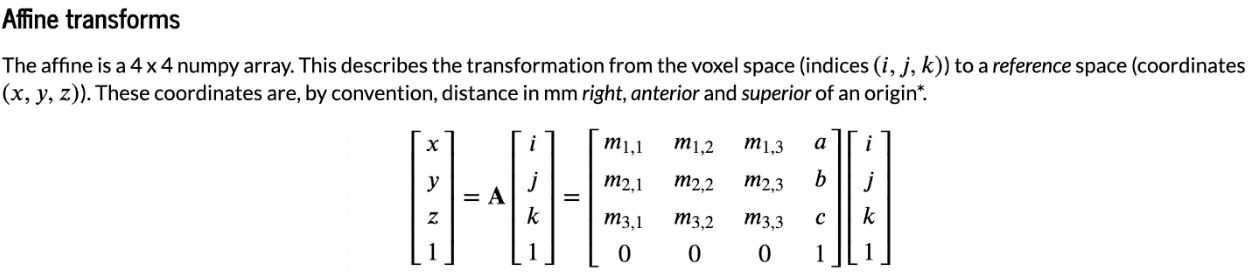

Native space:
 [[  -2.    0.    0.  114.]
 [   0.    2.    0.  -92.]
 [   0.    0.    2. -118.]
 [   0.    0.    0.    1.]]

Dimensions: (110, 110, 110) 


Data type: >f4


<OrthoSlicer3D: /content/gdrive/My Drive/TBIproject/ADNI/HC/ADNI_098_S_4275_MR_corrected_FA_image_Br_20140804132908542_S211937_I438192.nii (110, 110, 110)>

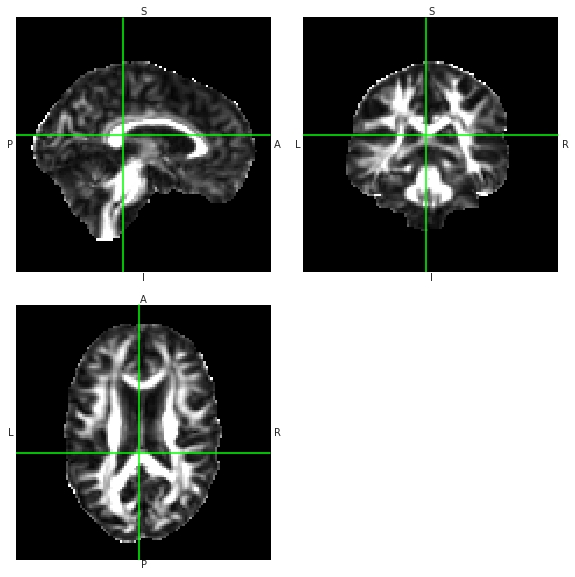

In [4]:
example = nib.load (HC_path / 'ADNI_098_S_4275_MR_corrected_FA_image_Br_20140804132908542_S211937_I438192.nii')
data = example.get_fdata()

"""Native space:"""
print("Native space:\n", example.affine)
"""Dimensions:"""
print("\nDimensions:", data.shape, "\n")
print("\nData type:",example.header.get_data_dtype())
example.orthoview()
#print(example.header)

###*Preparing the volumes*###

 To process the data, we do the following:
 * We first rotate the volumes by 90 degrees, so the orientation is fixed
 * We scale the values to be between 0 and 1.
 * We resize width, height and depth.
 Here we define several helper functions to process the data. These functions will be used when building training and validation datasets.

In [7]:
## ML specific libraries (Tensorflow, Keras)
#.Better loops/iterations (count, cycle, repeat)
from itertools import chain
from sklearn.model_selection import train_test_split
#.Tensorflow
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 110
    desired_width = 110
    desired_height = 110
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
MCI_vols = np.array([process_scan(path) for path in MCI_vols])
HC_vols = np.array([process_scan(path) for path in HC_vols])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

## Data augmentation
# Volumes are also augmented by rotating at random angles during training. Since
# the data is stored in rank-3 tensors of shape (samples, height, width, depth),
# we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
# the data. The new shape is thus (samples, height, width, depth, 1). There are
# different kinds of preprocessing and augmentation techniques out there,
# this example shows a few simple ones to get started.

import random

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


# While defining the train and validation data load, the training data is passed 
# through and augmentation function which randomly rotates volume at different 
# angles. Note that both training and validation data are already rescaled to 
# have values between 0 and 1.

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# https://user-images.githubusercontent.com/22832406/36989951-2b511f98-2071-11e8-9d81-f14baf260bc5.png
def read_nifti_file(HC_vols):
    scan = nib.load(HC_vols)
    scan = scan.get_fdata()
    return scan

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    return volume


/content/gdrive/My Drive/TBIproject/ADNI/HC


##*Approach to feature extraction*##

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
   1/1875 [..............................] - ETA: 0s - loss: 2.5035 - accuracy: 0.1250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2226 - accuracy: 0.9334 - val_loss: 0.1043 - val_accuracy: 0.9681
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0980 - accuracy: 0.9700 - val_loss: 0.0857 - val_accuracy: 0.9736
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0705 - accuracy: 0.9782 - val_loss: 0.0733 - val_accuracy: 0.9777
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0531 - accuracy: 0.9830 - val_loss: 0.0634 - val_accuracy: 0.9817

IndexError: ignored

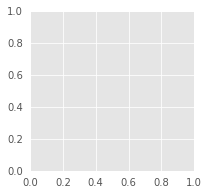

In [ ]:
### In machine learning, to improve something you often need to be able to measure it. TensorBoard is a tool for providing the measurements and 
##  visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model 
##  graph, projecting embeddings to a lower dimensional space, and much more.

import tensorflow as tf
import datetime
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
#rm -rf ./logs/
### Using the MNIST dataset as the example, normalize the data and write a function that creates a simple Keras model for classifying the images 
### into 10 classes.
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

### When training with Keras's Model.fit(), adding the tf.keras.callbacks.TensorBoard callback ensures that logs are created and stored. 
### Additionally, enable histogram computation every epoch with histogram_freq=1 (this is off by default)

### Place the logs in a timestamped subdirectory to allow easy selection of different training runs.
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

train_files = []
#mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
#

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

#Create data frame and split data on train set, validation set and test set
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

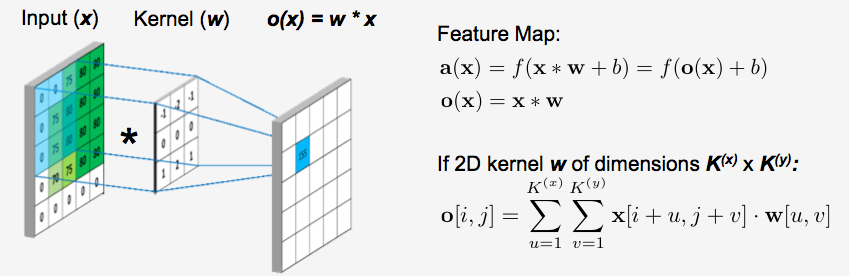###*Layers and Model Specification*###

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

#Check summary
model.summary()

###*Training*###

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

###*Benchmarking*###

In [ ]:
### Benchmarking 2D before attempting training

%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((110, 110, 110, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((110, 110, 110, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# Warm up
cpu()
gpu()

# Output
print('Time (s) to convolve ')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
#print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))
print('Time expected per 100 subjects, 15 layers:',((gpu_time)*1500), 'seconds')

Time expected per 100 subjects, 15 layers: 184.19416650002063 seconds


###*GPU/Parallel Parameters*###

In [ ]:
### Parallel processing parameter initialisation
# Distributed learning on the cloud TPUs on several workers
#.Multiple instances
multiworker_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
    tf.distribute.experimental.CollectiveCommunication.NCCL)

#.GPU assignation
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
    #cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    #cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
    #tpu_strategy = tf.distribute.TPUStrategy(cluster_resolver)

#3. Results#

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

#Print
print(test_acc)

##3.2 3D-CNN classification with learning transfer: Deep Clinic approach##

Usign a batch and making a representation of the feature extraction at the convolution and contextual comparison

##*Model Evaluation*##

##*Classification Results*##

#4. Interpretability and reproducibility: Reverse classification accuracy# 

In [ ]:
###TBA

#5. Discussion and conclussions#

